# Import needed libraries.

In [50]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

# Scrape statistics from official silesian police website and save them by year to appropriate CSV files.

In [25]:
all_data = pd.DataFrame()
temp_data = pd.DataFrame()
year = 2020
for i in range(1, 143):
    df = pd.read_html(f'http://www.slaska.policja.gov.pl/kat/form/23,Statystyki.html?page={i}')
    if not all_data.empty:
        if df[0]["Data"].loc()[0][:4] != str(year):
            temp_data = all_data.copy()[(all_data["Data"] > f"{year-1}-12-31") & (all_data["Data"] < f"{year+1}-01-01")]
            temp_data.sort_values(by=["Data"], inplace=True)
            temp_data.set_index("Data", inplace=True)
            temp_data.to_csv(f"datasets/Test/{year}_silesia.csv")
            year -= 1
            temp_data = pd.DataFrame()
        all_data = pd.concat([all_data, df[0]], sort=False)
    else:
        all_data = df[0]
    time.sleep(1)
all_data.sort_values(by=["Data"], inplace=True)
all_data.set_index("Data", inplace=True)
all_data.to_csv(f"datasets/from_{year}_to_2020.csv")

# Translate categories to english

In [58]:
all_data.columns = ['Robberies', 'Batteries', 'Burglaries', 'Thefts', 'Traffic accidents with injured', 'Fatalities in traffic accidents', 'Injured in traffic accidents', 'Drunk drivers', 'Traffic accidents without injured']

# Get heat map of correlation between commited crimes.

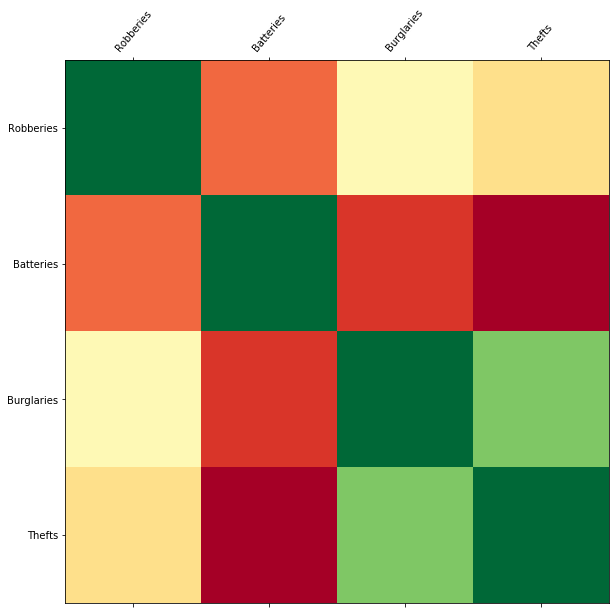

,Robberies,Batteries,Burglaries,Thefts
Robberies,1.000000,0.379305,0.600835,0.537193
Batteries,0.379305,1.000000,0.315882,0.229441
Burglaries,0.600835,0.315882,1.000000,0.814727
Thefts,0.537193,0.229441,0.814727,1.000000


In [81]:
all_data_without_traffic_accidents = all_data.copy().drop(['Traffic accidents with injured', 'Drunk drivers', 'Fatalities in traffic accidents', 'Injured in traffic accidents', 'Traffic accidents without injured'], axis=1)
labels = [l for l in all_data_without_traffic_accidents]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.matshow(all_data_without_traffic_accidents.corr(), cmap=plt.cm.RdYlGn)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=50)
ax.set_yticklabels(labels)
plt.show()
all_data_without_traffic_accidents.corr()

In [79]:
road_accidents_data = all_data.copy()[['Drunk drivers', 'Traffic accidents with injured', 'Fatalities in traffic accidents', 'Injured in traffic accidents', 'Traffic accidents without injured']]

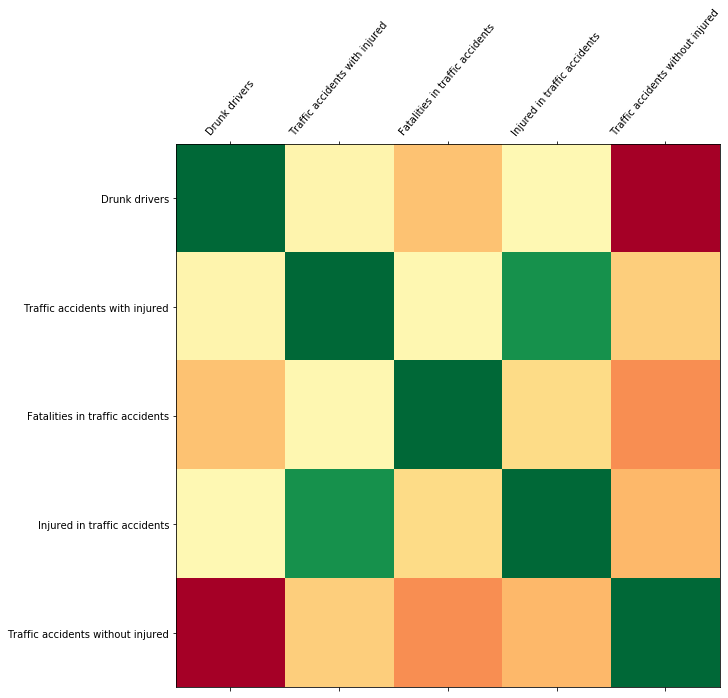

,Drunk drivers,Traffic accidents with injured,Fatalities in traffic accidents,Injured in traffic accidents,Traffic accidents without injured
Drunk drivers,1.000000,0.286639,0.117472,0.300454,-0.338082
Traffic accidents with injured,0.286639,1.000000,0.295924,0.880361,0.149098
Fatalities in traffic accidents,0.117472,0.295924,1.000000,0.186968,0.001142
Injured in traffic accidents,0.300454,0.880361,0.186968,1.000000,0.090833
Traffic accidents without injured,-0.338082,0.149098,0.001142,0.090833,1.000000


In [80]:
labels = [l for l in road_accidents_data]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.matshow(road_accidents_data.corr(), cmap=plt.cm.RdYlGn)
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=50)
ax.set_yticklabels(labels)
plt.show()
road_accidents_data.corr()

# Group data by years and months for better clarity of plot.

In [92]:
df = all_data_without_traffic_accidents.reset_index()
df.rename(columns={'Data': 'Date'}, inplace=True)

In [106]:
crimes_by_month = pd.DataFrame(columns=['Year', 'Month', 'Robberies', 'Batteries', 'Burglaries', 'Thefts'])
for day, robberies, batteries, burglaries, thefts in zip(df['Date'], df['Robberies'], df['Batteries'], df['Burglaries'], df['Thefts']):
    month = day[-5:-3]
    year = day[:4]
    if month[0] == "0":
        month = int(month[1])
    else:
        month = int(month)
    record = pd.DataFrame([[year, month, robberies, batteries, burglaries, thefts]], columns=['Year', 'Month', 'Robberies', 'Batteries', 'Burglaries', 'Thefts'])
    crimes_by_month = crimes_by_month.append(record, ignore_index=True)

In [147]:
gb = crimes_by_month.groupby('Year')

# Make graph from data between 2009 and 2019.

In [311]:
labels = []
for year in crimes_by_month['Year'].unique()[1:12]:
    for i in range(1,13):
        if i in [6,12]:
            labels.append(f"{year}-{i}")
        else:
            labels.append('')

In [297]:
stats = {'Thefts': [], 'Robberies': [], 'Batteries': [], 'Burglaries': []}
for year in crimes_by_month['Year'].unique()[1:12]:
    crimes = gb.get_group(year)
    for col in crimes.drop(['Year', 'Month'], axis=1):
        for month in range(1,13):
            mean_value = crimes[(crimes['Month'] == month)][[col]]
            if not mean_value.empty:
                stats[col].append(mean_value.mean().values[0])
        


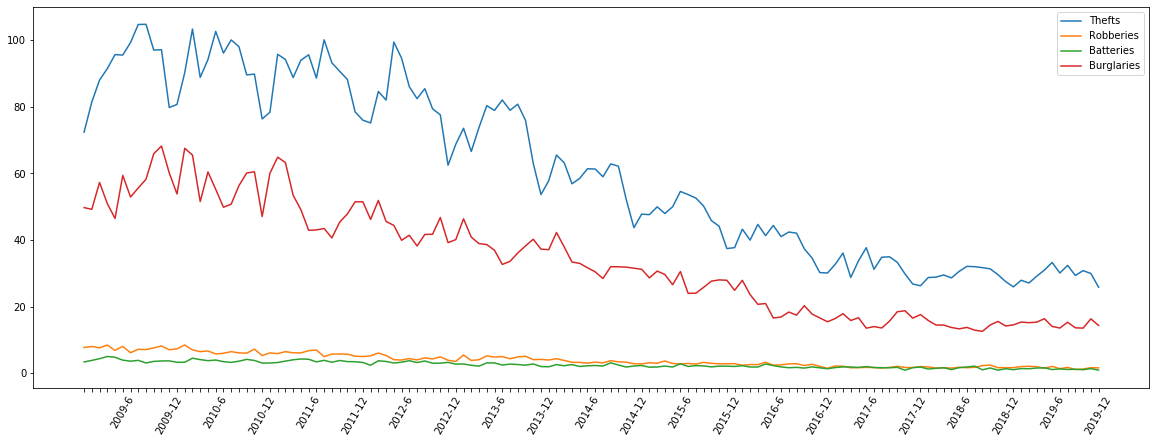

In [316]:
plt.figure(figsize=(20,7))
X = np.arange(len(labels))
plt.xticks(X, labels, rotation=60)
for name in stats:
    plt.plot(X, stats[name], label=name)
plt.legend()
plt.show()